In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predictive-maintenance-dataset-ai4i-2020/ai4i2020.csv


About Dataset

This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns

1.UID: unique identifier ranging from 1 to 10000

2.product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number

3.type: just the product type L, M or H from column 2

4.air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

5.process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

6.rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise

7.torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.

8.tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

9.a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.



The machine failure consists of five independent failure modes

1.tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).

2.heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.

3.power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

4.overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.

5.random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

# 1. Learn about basic information about the data set

* 1.1 Import relevant packages and set parameters for visualization

In [55]:
import pandas as pd
import numpy as np

from IPython.core.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio  

import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import warnings

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", 500)
pd.set_option('display.expand_frame_repr', False)  
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

pio.renderers.default = 'iframe'
pio.templates['ck_template'] = go.layout.Template(
    layout_colorway=px.colors.sequential.Viridis,
    layout_autosize=False,
    layout_width=800,
    layout_height=600,
    layout_font=dict(family="Calibri Light"),
    layout_title_font=dict(family="Calibri"),
    layout_hoverlabel_font=dict(family="Calibri Light")
)

pio.templates.default = 'ck_template+gridon'

* 1.2 Load data set and print some basic information

In [56]:
df = pd.read_csv('/kaggle/input/predictive-maintenance-dataset-ai4i-2020/ai4i2020.csv')
df.info(),df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

(None,
    UDI Product ID Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF
 0    1     M14860    M                298.1                    308.6                    1551         42.8                0                0    0    0    0    0    0
 1    2     L47181    L                298.2                    308.7                    1408         46.3                3                0    0    0    0    0    0
 2    3     L47182    L                298.1                    308.5                    1498         49.4                5                0    0    0    0    0    0
 3    4     L47183    L                298.2                    308.6                    1433         39.5                7                0    0    0    0    0    0
 4    5     L47184    L                298.2                    308.7                    1408         40.0                9                0    0    0    0    0   

In [57]:
for column in df.columns:
    try:
        df[column] = df[column].astype(float)
    except:
        pass
    
# Perform a data type conversion
print(df.info(), df.head())  
df_numeric = df.select_dtypes(include=[np.number])
print(df_numeric.describe(include='all').T)   # In addition to describe continuous data, we also describe discrete data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  float64
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  float64
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  float64
 8   Machine failure          10000 non-null  float64
 9   TWF                      10000 non-null  float64
 10  HDF                      10000 non-null  float64
 11  PWF                      10000 non-null  float64
 12  OSF                      10000 non-null  float64
 13  RNF                      10000 non-null  float64
dtypes: float64(12), object(

* 1.3 Draw relationship figures between attributes and factors

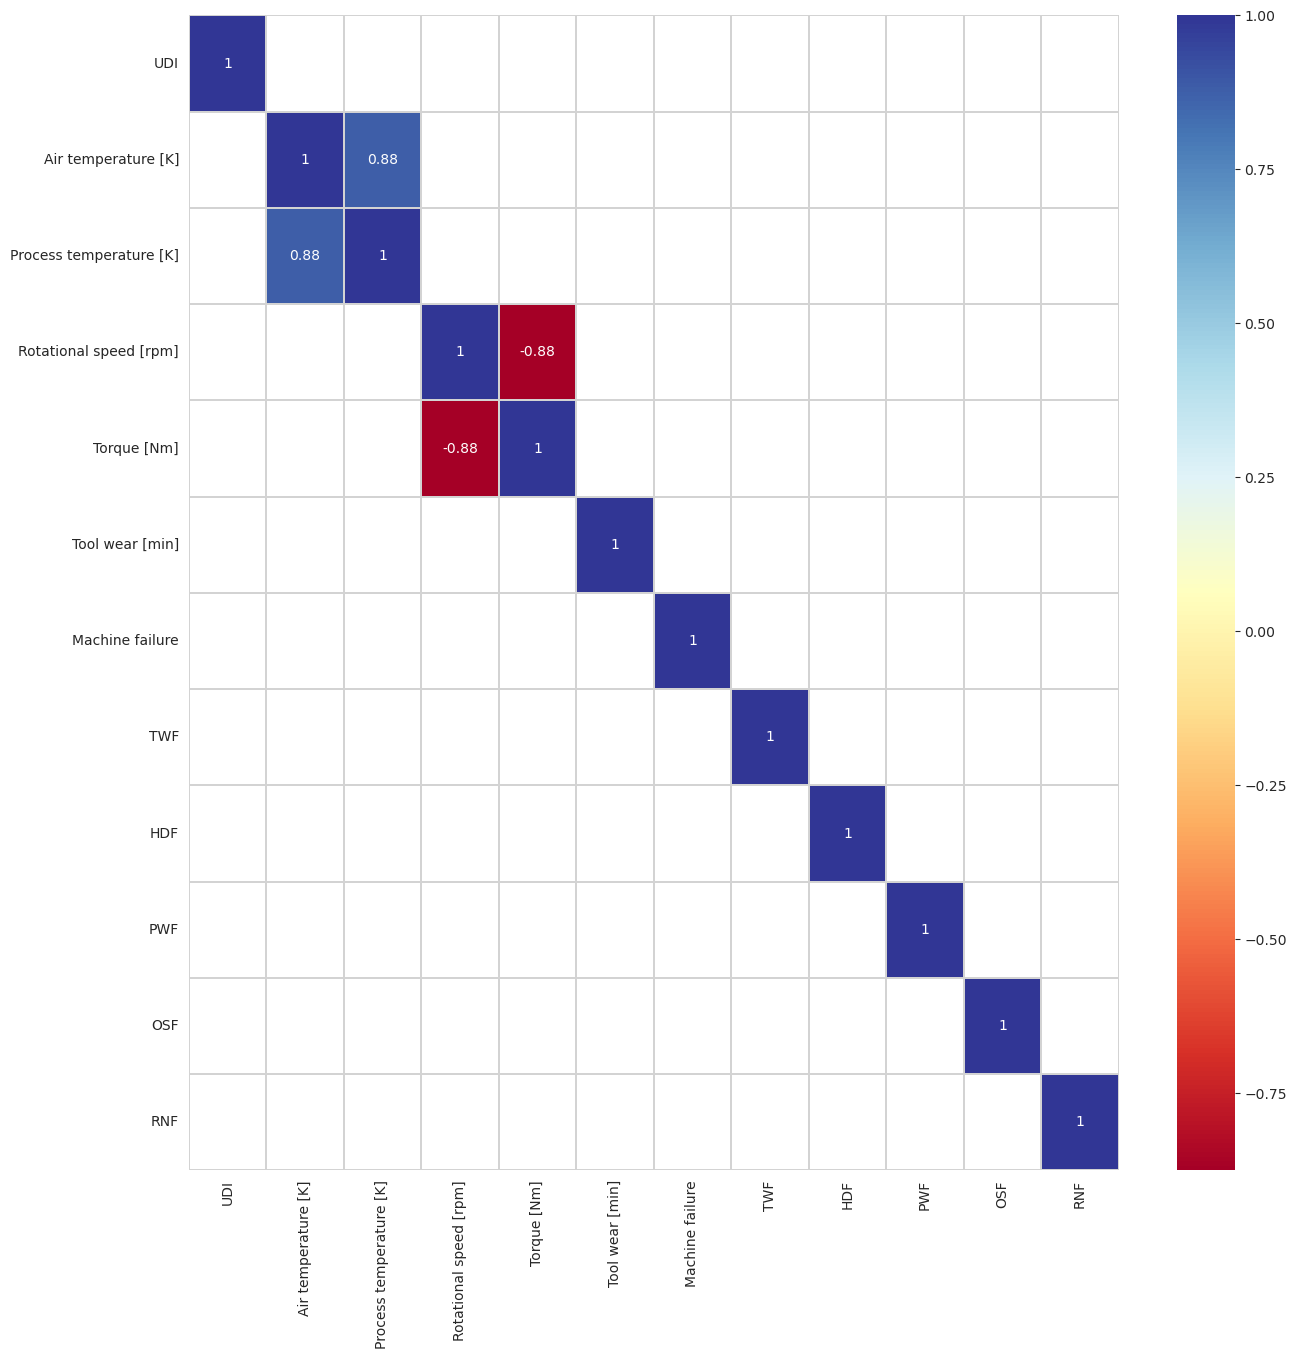

In [58]:
plt.figure(figsize=(15, 15))
threshold = 0.8
sns.set_style('whitegrid', {'axes.facecolor': ".0"})
df_cluster2 = df.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws = {'s': 1}

sns.heatmap(df_cluster2,
            cmap='RdYlBu',  
            annot=True,  
            mask=mask,
            linewidth=0.20,  
            linecolor='lightgrey').set_facecolor('white')  

plt.show()  

We can see from the image that there is a strong correlation between process temperature and air temperature and a strong correlation between torque and rotational speed

*  1.4 Use module "ProfileReport" to generate detailed analysis reports of the data set

In [59]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df,
                        title="Predictive Maintenance",
                        dataset={"description": "This profiling report was generated for jiejie",
                                 "copyright_holder": "jiejie",
                                 "copyright_year": "2023"},
                        explorative=True
                        )
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [61]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1.0,M14860,M,298.1,308.6,1551.0,42.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,L47181,L,298.2,308.7,1408.0,46.3,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,L47182,L,298.1,308.5,1498.0,49.4,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,L47183,L,298.2,308.6,1433.0,39.5,7.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,L47184,L,298.2,308.7,1408.0,40.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  float64
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  float64
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  float64
 8   Machine failure          10000 non-null  float64
 9   TWF                      10000 non-null  float64
 10  HDF                      10000 non-null  float64
 11  PWF                      10000 non-null  float64
 12  OSF                      10000 non-null  float64
 13  RNF                      10000 non-null  float64
dtypes: float64(12), object(

In [63]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [64]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [65]:
df=df.drop(["UDI","Product ID"], axis = 1)

In [66]:
df = pd.get_dummies(df, columns=["Type"], drop_first = True)

# 2. Data Preparing

In [69]:
#df.drop(['UDI', 'Product ID'], axis=1, inplace=True)  # Delete variables that are not helpful to predict
print(df.head())

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  Type_L  Type_M
0                298.1                    308.6                  1551.0         42.8              0.0              0.0  0.0  0.0  0.0  0.0  0.0       0       1
1                298.2                    308.7                  1408.0         46.3              3.0              0.0  0.0  0.0  0.0  0.0  0.0       1       0
2                298.1                    308.5                  1498.0         49.4              5.0              0.0  0.0  0.0  0.0  0.0  0.0       1       0
3                298.2                    308.6                  1433.0         39.5              7.0              0.0  0.0  0.0  0.0  0.0  0.0       1       0
4                298.2                    308.7                  1408.0         40.0              9.0              0.0  0.0  0.0  0.0  0.0  0.0       1       0


In [70]:
df['Machine failure'].value_counts()  #

0.0    9661
1.0     339
Name: Machine failure, dtype: int64

In [71]:
df['TWF'].value_counts()

0.0    9954
1.0      46
Name: TWF, dtype: int64

In [72]:
df['HDF'].value_counts()

0.0    9885
1.0     115
Name: HDF, dtype: int64

In [73]:
df['PWF'].value_counts()

0.0    9905
1.0      95
Name: PWF, dtype: int64

In [74]:
df['OSF'].value_counts()

0.0    9902
1.0      98
Name: OSF, dtype: int64

In [75]:
df['RNF'].value_counts()

0.0    9981
1.0      19
Name: RNF, dtype: int64

In [82]:
X = df.drop("Machine failure", axis=1)
y = df["Machine failure"]
print(X.head())
print(y.head())



   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Type_L  Type_M
0                298.1                    308.6                  1551.0         42.8              0.0       0       1
1                298.2                    308.7                  1408.0         46.3              3.0       1       0
2                298.1                    308.5                  1498.0         49.4              5.0       1       0
3                298.2                    308.6                  1433.0         39.5              7.0       1       0
4                298.2                    308.7                  1408.0         40.0              9.0       1       0
0    0
1    0
2    0
3    0
4    0
Name: Machine failure, dtype: int64


In [83]:
df = pd.get_dummies(df, drop_first=True)  # Achieve ont_hot_encode

In [84]:
features = list(df.columns)  # Deal with special values and nan 

df.replace("?", np.nan, inplace=True)

num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
for feature in features:
    try:
        df[feature].fillna(df[feature].mean(), inplace=True)
    except:
        try:
            df[feature].fillna(df[feature].mode(), inplace=True)
        except:
            pass
        
for feature in features:
    print(feature + "-" + str(
        len(df[df[feature].isna()])))  

Air temperature [K]-0
Process temperature [K]-0
Rotational speed [rpm]-0
Torque [Nm]-0
Tool wear [min]-0
Machine failure-0
Type_L-0
Type_M-0


# 3. Cluster analyse

In [85]:
sns.set_style('white')
plot_kws = {"s": 1}
# g = sns.pairplot(df,
#                 diag_kind='hist',
#                 corner=False,
#                 palette='cividis',
#                 hue='Machine failure')  
#plt.show()  

In [86]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
X_features = df_numeric.drop("Machine failure", axis=1)
pca=PCA()
X_pca=pca.fit_transform(df_numeric)  
component_names=[f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca=pd.DataFrame(X_pca,columns=component_names)
X_pca['Machine failure']=df["Machine failure"]
print(X_pca.head(10))

sns.set_style('white')
plot_kws={"s":1}
#g=sns.pairplot(X_pca,diag_kind='hist',corner=False,palette='cividis',hue='Machine failure')
#plt.show()  

           PC1         PC2         PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10      PC11      PC12  Machine failure
0 -4999.479262   10.003017 -109.134424  3.296706 -1.522787  0.379787 -0.030726 -0.011699 -0.034502  0.019372 -0.002245  0.002102                0
1 -4998.420935 -132.997315 -106.123193 -0.158838 -1.313737  0.401199  0.005783  0.008046 -0.007470  0.010798 -0.002313  0.001680                0
2 -4997.458529  -43.254110 -104.132371  7.312785 -1.597133  0.303190 -0.093004 -0.024411 -0.043784  0.030099 -0.003020  0.001274                0
3 -4996.432282 -107.695126 -102.121845 -5.732731 -1.336871  0.309250  0.078806  0.030264  0.011894 -0.004436 -0.001160  0.002195                0
4 -4995.422422 -132.689297 -100.119612 -6.447757 -1.268622  0.390694  0.088945  0.032248  0.017121 -0.006499 -0.001277  0.002220                0
5 -4994.429908 -115.801321  -98.121818 -3.723797 -1.435631  0.368133  0.052410  0.020355  0.005499  0.000475 -0.001592  0.00

In [87]:
from random import sample
from numpy.random import uniform
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import scale, normalize

X = df_numeric.drop("Machine failure", axis = 1)
y = df_numeric["Machine failure"]
print(X.dtypes)



# Define some new features from the original data and calculate the hopkins statistic 
# and Hopkins statistics for the dataframe X to determine the randomness of the data in space, 
# so as to determine whether the data can be clustered
def hopkins_statistic(X, k=2):
    try:
        X = X.values 
    except:
        pass
    X = normalize(X)

    sample_size = int(X.shape[0] * 0.05) 

    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0),
                                      (sample_size, X.shape[1]))  # A uniform random sample over the original data space

    random_indices = sample(range(0, X.shape[0], 1), k=sample_size)
    X_sample = X[random_indices]  # randomly extracted from the original data X according to random_indices

    neigh = NearestNeighbors(n_neighbors=k)  
    nbrs = neigh.fit(X)  # Initializes the unsupervised learning to implement neighbor searches

    u_distances, u_indices = nbrs.kneighbors(X_uniform_random_sample, n_neighbors=k)  
    u_distances = u_distances[:, 0]  

    w_distances, w_indices = nbrs.kneighbors(X_sample, n_neighbors=k)  
    w_distances = w_distances[:, 1]  

    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)

    H = u_sum / (u_sum + w_sum)
    return H


H = hopkins_statistic(X, 3)
print('Hopkins statistic:' + str(H))  

UDI                        float64
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]     float64
Torque [Nm]                float64
Tool wear [min]            float64
TWF                        float64
HDF                        float64
PWF                        float64
OSF                        float64
RNF                        float64
dtype: object
Hopkins statistic:0.9862247822320735


According to the scatter figure and Hopkins statistic, it is clear that use clustering analysis to explore the data set

# 4. Feature selecting

In [88]:
X = df_numeric.drop("Machine failure", axis = 1)
y = df_numeric["Machine failure"]
print(X.dtypes)

# Obtain training data set and testing data set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Normalization to avoid skewed data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = pd.DataFrame(
    sc.fit_transform(X_train),
    columns =X.columns
)
X_test = pd.DataFrame(
    sc.transform(X_test),
    columns = X.columns
)

UDI                        float64
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]     float64
Torque [Nm]                float64
Tool wear [min]            float64
TWF                        float64
HDF                        float64
PWF                        float64
OSF                        float64
RNF                        float64
dtype: object


In [89]:
Selected_Features = []
import statsmodels.api as sm

def backward_regression(X, y, initial_list=[], threshold_out=0.05, verbose=True):  # threshold_out corresponds to P-values
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


backward_regression(X, y)

X.head()
feature_names = list(X.columns)
print(np.shape(X), len(feature_names)) 

worst_feature : RNF, 0.987582166954049 
worst_feature : Tool wear [min], 0.4809802627739731 
worst_feature : Air temperature [K], 0.33098800878615675 
worst_feature : Process temperature [K], 0.4154020738160744 
worst_feature : UDI, 0.3639711521522496 

Selected Features:
['Rotational speed [rpm]', 'Torque [Nm]', 'TWF', 'HDF', 'PWF', 'OSF']
(10000, 11) 11


# 5. Data modeling

In [90]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, \
    plot_confusion_matrix, matthews_corrcoef
import time

model_performance = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1-Score', 'MCC score',
                                          'time to train', 'time to predict', 'total time'])

Accuracy: 99.80% 
Recall: 99.80% 
Precison: 99.80% 
F1-Score: 99.80% 
MCC: 96.91% 
time to train: 0.01 s 
time to predict: 0.11 s 
total: 0.12 s


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



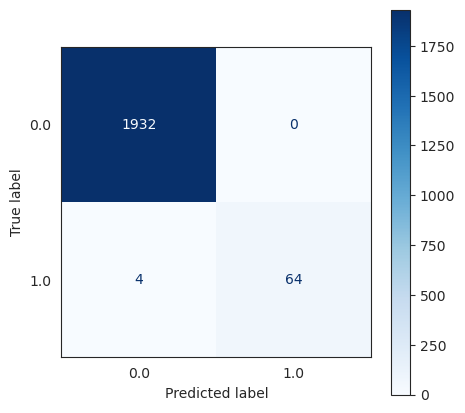

In [91]:
# KNN model
from sklearn.neighbors import KNeighborsClassifier

start = time.time()
model = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
end_train = time.time()
y_pred = model.predict(X_test)
end_predict = time.time()

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1s = f1_score(y_test, y_pred, average = "weighted")
MCC = matthews_corrcoef(y_test, y_pred)

print("Accuracy: " + "{:.2%}".format(accuracy),
      "\nRecall: " + "{:.2%}".format(recall),
      "\nPrecison: " + "{:.2%}".format(precision),
      "\nF1-Score: " + "{:.2%}".format(f1s),
      "\nMCC: " + "{:.2%}".format(MCC),
      "\ntime to train: " + "{:.2f}".format(end_train - start) + " s",
      "\ntime to predict: " + "{:.2f}".format(end_predict - end_train) + " s",
      "\ntotal: " + "{:.2f}".format(end_predict - start) + " s"
      )
model_performance.loc['KNN'] = [accuracy, recall, precision, f1s, MCC, end_train - start, end_predict - end_train,
                                     end_predict - start]

plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.size'] = 10
sns.set_style('white')
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

Accuracy: 99.80% 
Recall: 99.80% 
Precison: 99.80% 
F1-Score: 96.97% 
MCC: 96.91% 
time to train: 0.03 s 
time to predict: 0.00 s 
total: 0.03 s


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



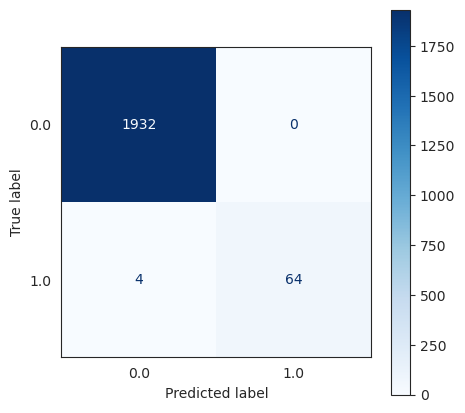

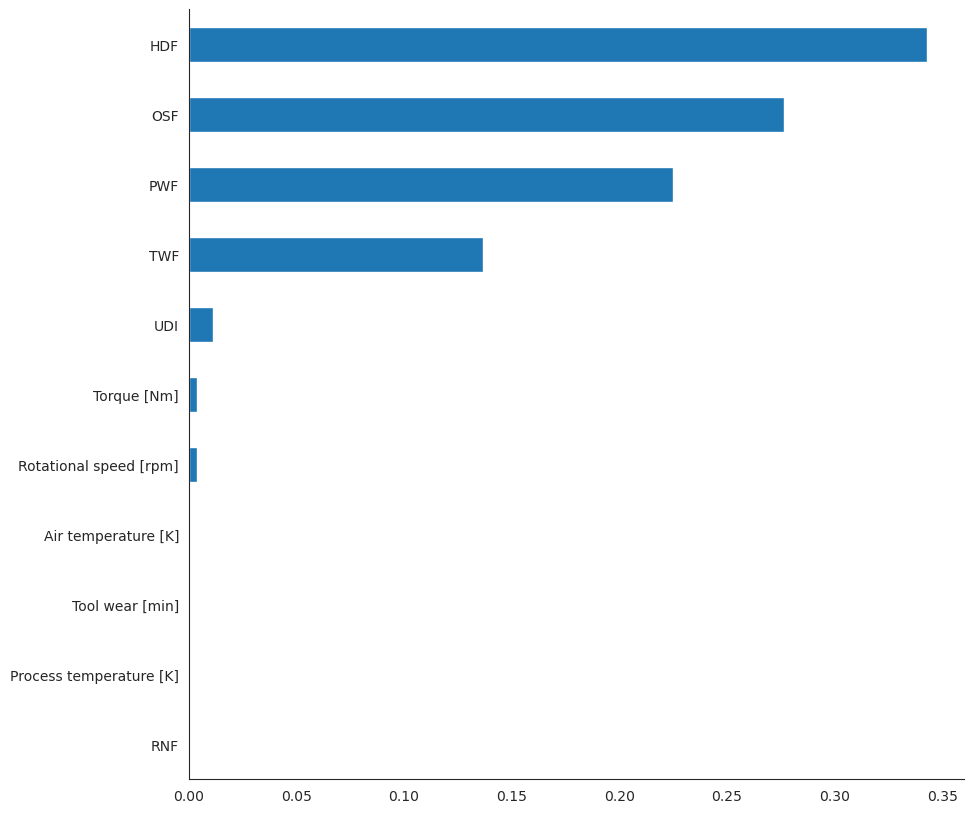

In [93]:
# Decidion Tree
from sklearn.tree import DecisionTreeClassifier

start = time.time()
model = DecisionTreeClassifier().fit(X_train, y_train)
end_train = time.time()
y_pred = model.predict(X_test)
end_predict = time.time()

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1s = f1_score(y_test, y_pred)
MCC = matthews_corrcoef(y_test, y_pred)

print("Accuracy: " + "{:.2%}".format(accuracy),
      "\nRecall: " + "{:.2%}".format(recall),
      "\nPrecison: " + "{:.2%}".format(precision),
      "\nF1-Score: " + "{:.2%}".format(f1s),
      "\nMCC: " + "{:.2%}".format(MCC),
      "\ntime to train: " + "{:.2f}".format(end_train - start) + " s",
      "\ntime to predict: " + "{:.2f}".format(end_predict - end_train) + " s",
      "\ntotal: " + "{:.2f}".format(end_predict - start) + " s"
      )
model_performance.loc['Decision Tree'] = [accuracy, recall, precision, f1s, MCC, end_train - start,
                                          end_predict - end_train, end_predict - start]

plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.size'] = 10
sns.set_style('white')
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

plt.rcParams['figure.figsize'] = 10, 10
sns.set_style('white')
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean() 
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()  
sns.despine()  
plt.show()

Accuracy: 99.80% 
Recall: 99.80% 
Precison: 99.80% 
F1-Score: 96.97% 
MCC: 96.91% 
time to train: 0.33 s 
time to predict: 0.10 s 
total: 0.44 s


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



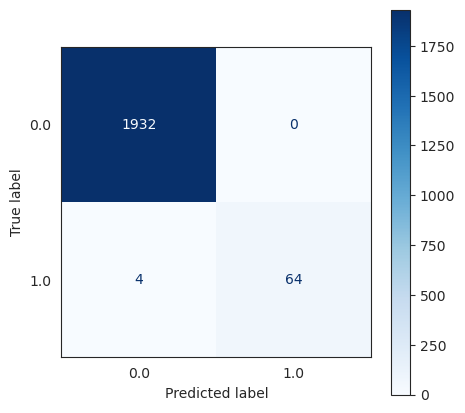

In [94]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

start = time.time()
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0, bootstrap=True).fit(X_train, y_train)
end_train = time.time()
y_pred = model.predict(X_test)
end_predict = time.time()

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1s = f1_score(y_test, y_pred)
MCC = matthews_corrcoef(y_test, y_pred)

print("Accuracy: " + "{:.2%}".format(accuracy),
      "\nRecall: " + "{:.2%}".format(recall),
      "\nPrecison: " + "{:.2%}".format(precision),
      "\nF1-Score: " + "{:.2%}".format(f1s),
      "\nMCC: " + "{:.2%}".format(MCC),
      "\ntime to train: " + "{:.2f}".format(end_train - start) + " s",
      "\ntime to predict: " + "{:.2f}".format(end_predict - end_train) + " s",
      "\ntotal: " + "{:.2f}".format(end_predict - start) + " s"
      )
model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s, MCC, end_train - start,
                                          end_predict - end_train, end_predict - start]

plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.size'] = 10
sns.set_style('white')
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

Accuracy: 99.80% 
Recall: 99.80% 
Precison: 99.80% 
F1-Score: 96.97% 
MCC: 96.91% 
time to train: 1.03 s 
time to predict: 0.00 s 
total: 1.04 s


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



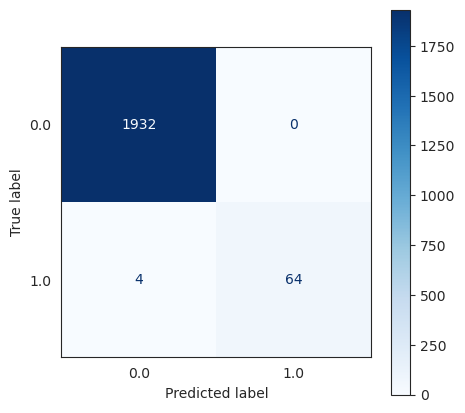

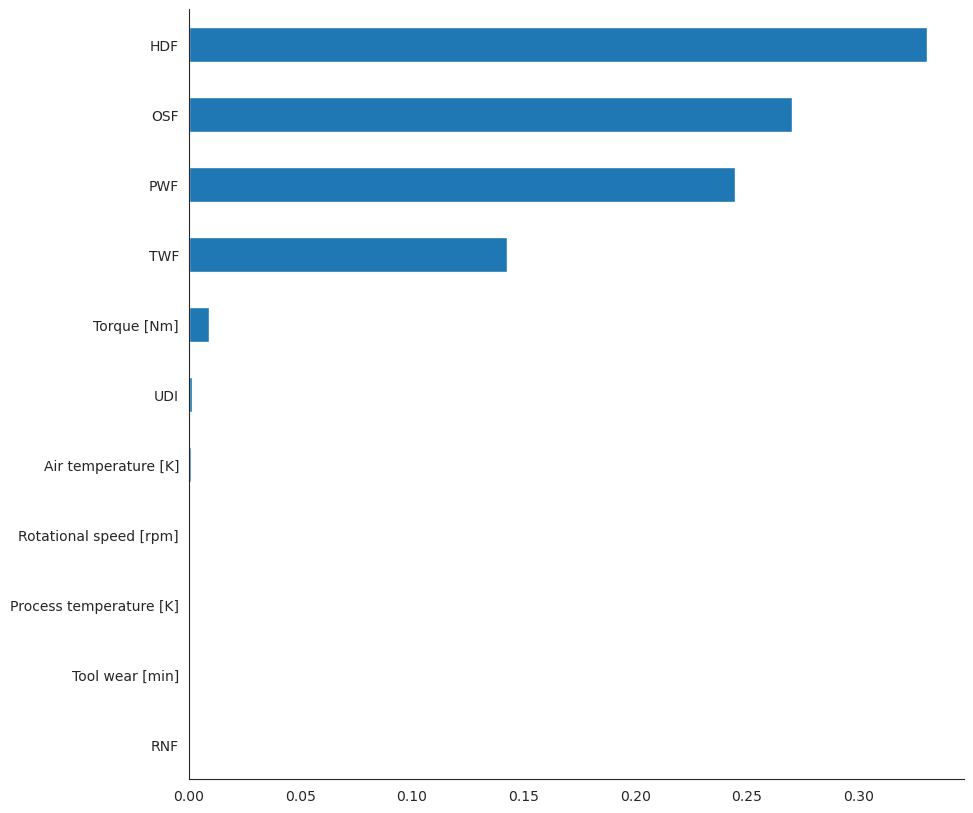

In [95]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

start = time.time()
model = GradientBoostingClassifier().fit(X_train, y_train)
end_train = time.time()
y_pred = model.predict(X_test)
end_predict = time.time()

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1s = f1_score(y_test, y_pred)
MCC = matthews_corrcoef(y_test, y_pred)

print("Accuracy: " + "{:.2%}".format(accuracy),
      "\nRecall: " + "{:.2%}".format(recall),
      "\nPrecison: " + "{:.2%}".format(precision),
      "\nF1-Score: " + "{:.2%}".format(f1s),
      "\nMCC: " + "{:.2%}".format(MCC),
      "\ntime to train: " + "{:.2f}".format(end_train - start) + " s",
      "\ntime to predict: " + "{:.2f}".format(end_predict - end_train) + " s",
      "\ntotal: " + "{:.2f}".format(end_predict - start) + " s"
      )
model_performance.loc['Gradient Boosting'] = [accuracy, recall, precision, f1s, MCC, end_train - start,
                                              end_predict - end_train, end_predict - start]

plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.size'] = 10
sns.set_style('white')
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

plt.rcParams['figure.figsize'] = 10, 10
sns.set_style('white')
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

Accuracy: 99.80% 
Recall: 99.80% 
Precison: 99.80% 
F1-Score: 99.80% 
MCC: 96.91% 
time to train: 1.59 s 
time to predict: 0.00 s 
total: 1.59 s


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



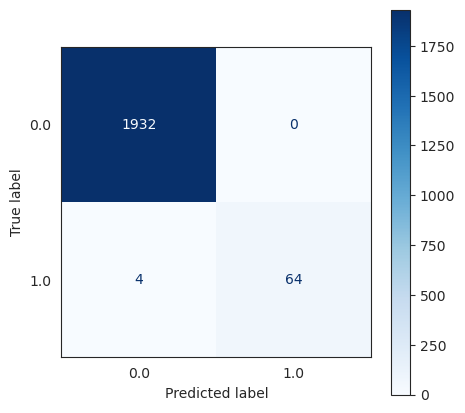

In [96]:
# Neural Network MLP
from sklearn.neural_network import MLPClassifier

start = time.time()
model = MLPClassifier(hidden_layer_sizes=(25, 25, 25),
                      activation='relu',
                      solver='adam',
                      batch_size=2000,
                      verbose=0).fit(X_train, y_train)
end_train = time.time()
y_pred = model.predict(X_test)
end_predict = time.time()

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1s = f1_score(y_test, y_pred, average = "weighted")
MCC = matthews_corrcoef(y_test, y_pred)

print("Accuracy: " + "{:.2%}".format(accuracy),
      "\nRecall: " + "{:.2%}".format(recall),
      "\nPrecison: " + "{:.2%}".format(precision),
      "\nF1-Score: " + "{:.2%}".format(f1s),
      "\nMCC: " + "{:.2%}".format(MCC),
      "\ntime to train: " + "{:.2f}".format(end_train - start) + " s",
      "\ntime to predict: " + "{:.2f}".format(end_predict - end_train) + " s",
      "\ntotal: " + "{:.2f}".format(end_predict - start) + " s"
      )
model_performance.loc['Neural Network MLP'] = [accuracy, recall, precision, f1s, MCC, end_train - start,
                                               end_predict - end_train, end_predict - start]

plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.size'] = 10
sns.set_style('white')
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [97]:
model_performance.fillna(.90, inplace=True)
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'MCC score': '{:.2%}',
                                                                     'time to train': '{:.1f}',
                                                                     'time to predict': '{:.1f}',
                                                                     'total time': '{:.1f}',
                                                                     })
print(model_performance)

                    Accuracy  Recall  Precision  F1-Score  MCC score  time to train  time to predict  total time
KNN                    0.998   0.998   0.998004  0.997971    0.96914       0.012552         0.107717    0.120269
Decision Tree          0.998   0.998   0.998004  0.969697    0.96914       0.029715         0.001501    0.031216
Random Forest          0.998   0.998   0.998004  0.969697    0.96914       0.333586         0.103523    0.437109
Gradient Boosting      0.998   0.998   0.998004  0.969697    0.96914       1.034030         0.002715    1.036746
Neural Network MLP     0.998   0.998   0.998004  0.997971    0.96914       1.586517         0.003371    1.589888


From above model, we can learn that Gradient Boosting classfieir and Neural Network MLP seem to be the go-to models for this case, giving a decent MCC score.